In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import PIL
import pathlib
import tensorflow as tf
import matplotlib.image as mpimg
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
model = keras.models.load_model('../../models/rnc_image_classification_model')

In [3]:
df = pd.read_csv('../preprocessing/holter_list.csv',sep=',')

In [4]:
df

,Signals,Header,Unaudited,Audited,Signal,VF Onset
0,30.dat,30.hea,30.ari,30.atr,24:33:17,07:54:33
1,31.dat,31.hea,31.ari,31.atr,13:58:40,13:42:24
2,32.dat,32.hea,32.ari,32.atr,24:20:00,16:45:18
3,33.dat,33.hea,33.ari,NaN,24:33:00,04:46:19
4,34.dat,34.hea,34.ari,34.atr,07:05:20,06:35:44
5,35.dat,35.hea,35.ari,35.atr,24:52:00,24:34:56
6,36.dat,36.hea,36.ari,36.atr,20:21:20,18:59:01
7,37.dat,37.hea,37.ari,NaN,25:08:00,01:31:13
8,38.dat,38.hea,38.ari,NaN,18:18:25,08:01:54
9,39.dat,39.hea,39.ari,NaN,05:47:00,04:37:51


In [5]:
df['filename'] = df['Signals'].str.replace(r'(\S+).dat',r'\1',regex=True) + '.txt'

In [6]:
lista_filenames = list(df['filename'].unique())

In [7]:
lista_filenames.remove('30.txt')
lista_filenames.remove('31.txt')
lista_filenames.remove('32.txt')
lista_filenames.remove('33.txt')
lista_filenames.remove('34.txt')
lista_filenames.remove('35.txt')
lista_filenames.remove('36.txt')
lista_filenames.remove('37.txt')
lista_filenames.remove('40.txt')
lista_filenames.remove('42.txt')
lista_filenames.remove('49.txt')

In [8]:
lista_filenames

['38.txt',
 '39.txt',
 '41.txt',
 '43.txt',
 '44.txt',
 '45.txt',
 '46.txt',
 '47.txt',
 '48.txt',
 '50.txt',
 '51.txt',
 '52.txt']

### Now doing predictions

In [9]:
img_height = 200
img_width = 400

In [10]:
class_names = ['healthy_patients', 'sudden_death_patients']

In [11]:
lista_filenames

['38.txt',
 '39.txt',
 '41.txt',
 '43.txt',
 '44.txt',
 '45.txt',
 '46.txt',
 '47.txt',
 '48.txt',
 '50.txt',
 '51.txt',
 '52.txt']

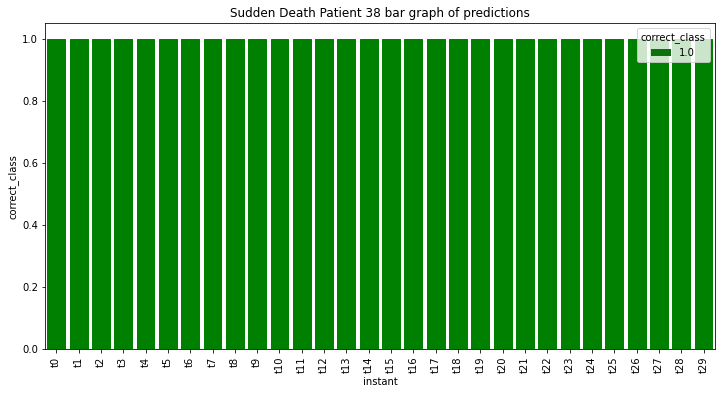

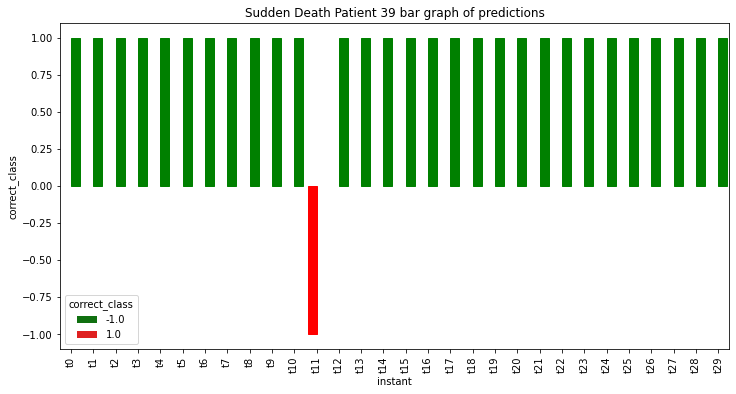

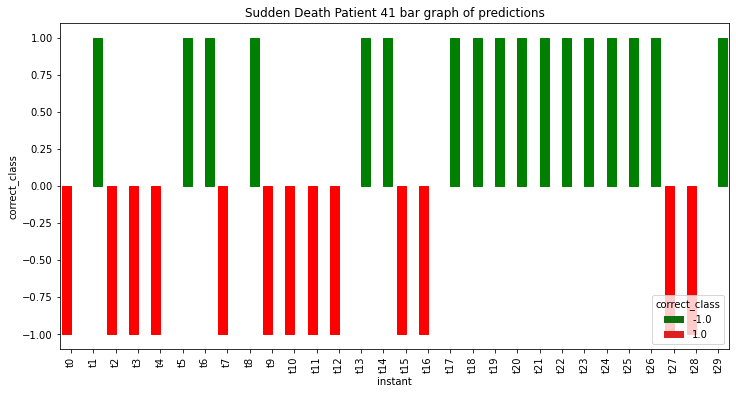

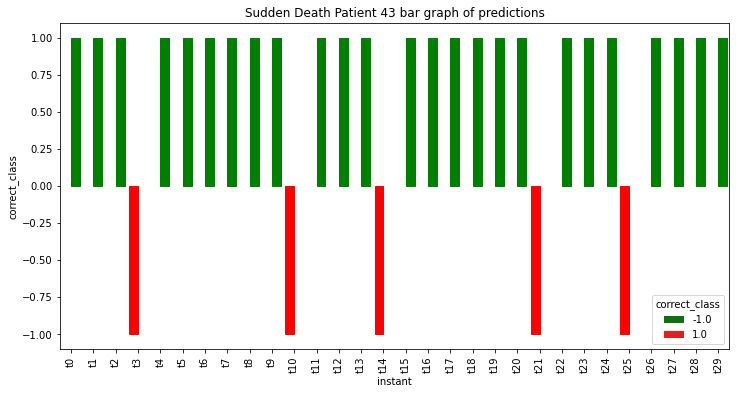

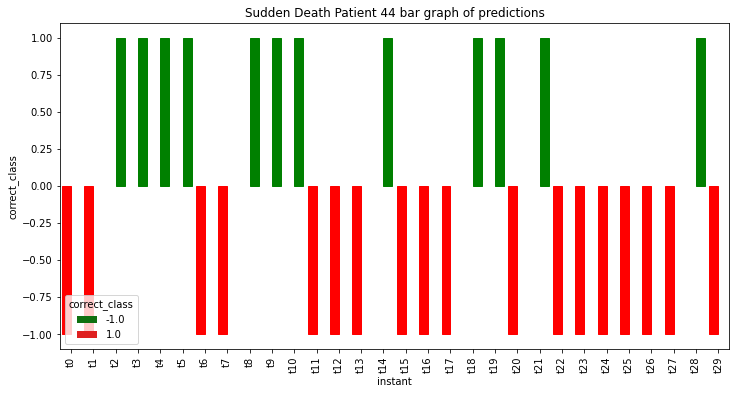

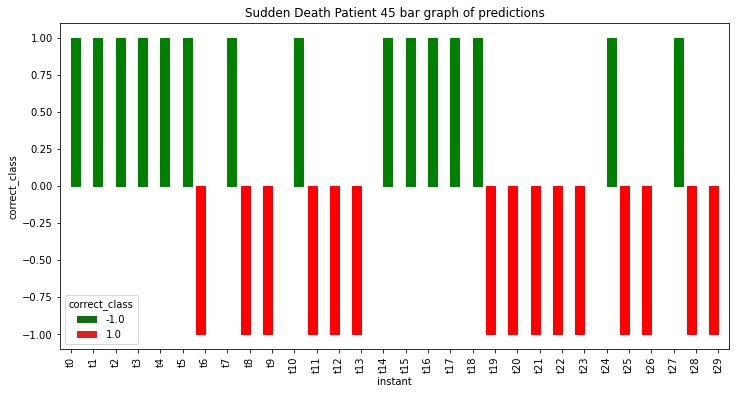

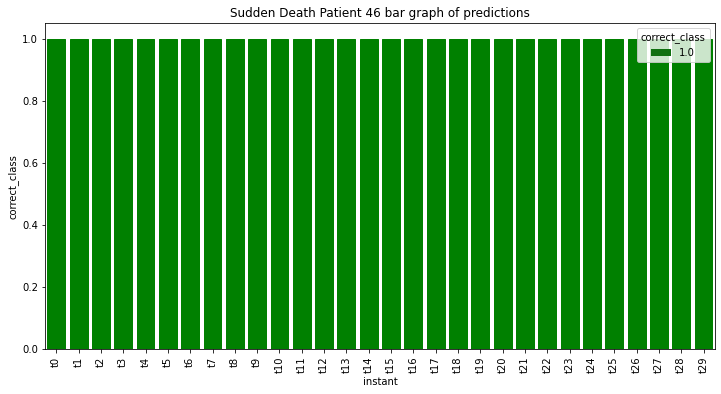

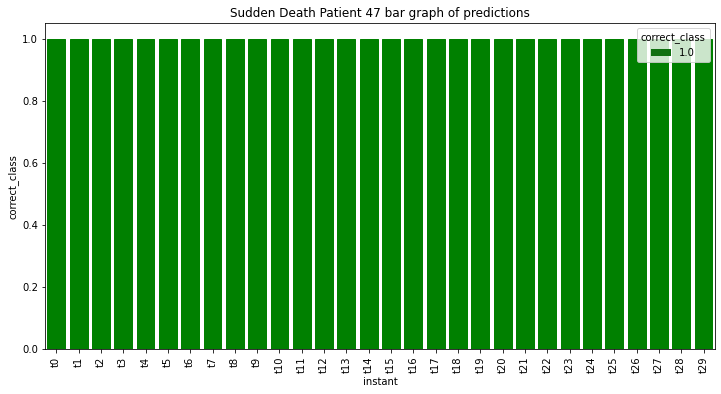

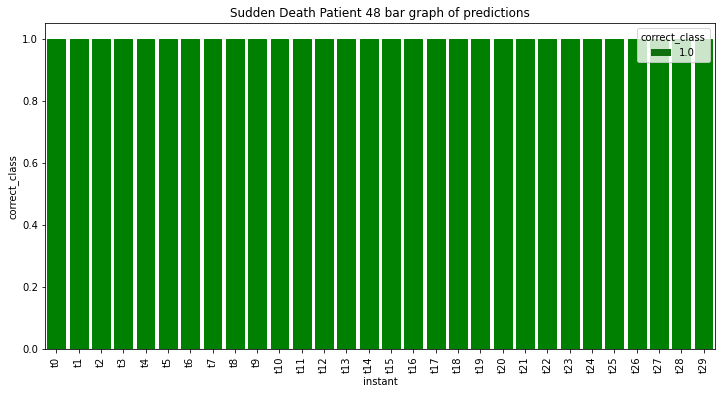

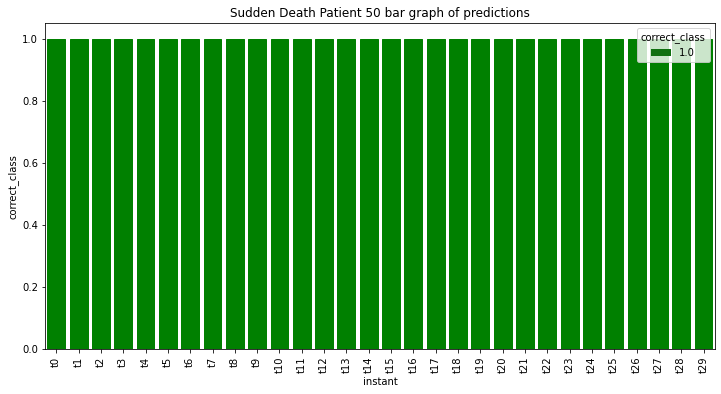

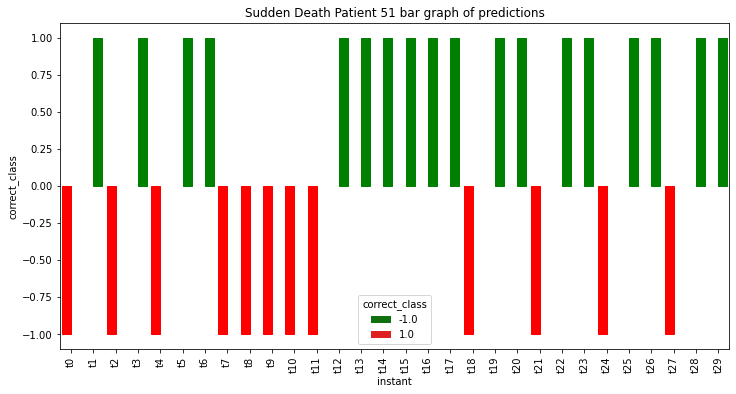

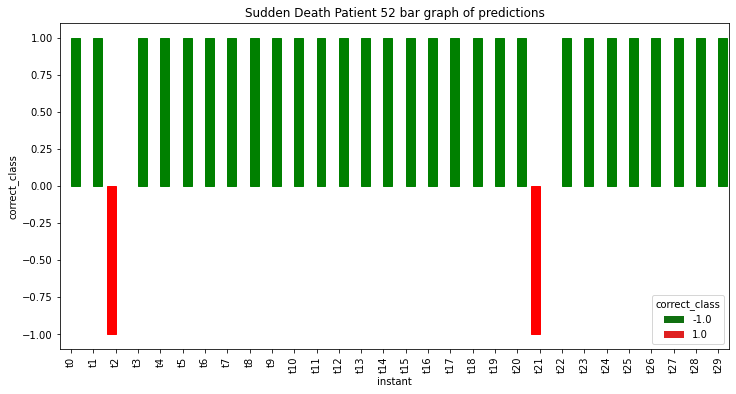

In [12]:
df_unhealthy_final = pd.DataFrame(columns = ['score','class','probability_0','probability_1','both_proba','instant','patient','instant_s'],index = range(360))
for filename in lista_filenames:
    name = filename.replace('.txt','')
    unhealthy = list(pathlib.Path(f'../../data/trials/{name}/').glob('data/*'))
    df_unhealthy = pd.DataFrame(columns = ['score','class','probability_0','probability_1','both_proba','instant','patient','instant_s'],index = range(len(unhealthy)))
    
    for i in range(len(unhealthy)):
        img = keras.preprocessing.image.load_img(
        unhealthy[i], target_size=(img_height, img_width)
        )

        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch

        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])
        score_healthy = float(score[0])
        score_unhealthy = float(score[1])

        both_scores = [score_healthy,score_unhealthy]

        df_unhealthy['score'].iloc[i] = 100 * np.max(score)
        df_unhealthy['class'].iloc[i] = class_names[np.argmax(score)]
        df_unhealthy['instant'].iloc[i] = f't{i}'

        df_unhealthy['probability_0'].iloc[i] = float(score[0])
        df_unhealthy['probability_1'].iloc[i] = float(score[1])
        df_unhealthy['both_proba'].iloc[i] = both_scores
        
        instant = unhealthy[i].name.replace('.png','').replace(r'txt_',r'')
        instant = instant.replace(f'{name}.','')
        df_unhealthy['instant_s'].iloc[i] = instant

    df_unhealthy['true'] = 'sudden_death_patients'
    
    df_unhealthy.loc[df_unhealthy['true'] != df_unhealthy['class'],'correct_class'] = -1
    df_unhealthy.loc[df_unhealthy['true'] == df_unhealthy['class'],'correct_class'] = 1
    df_unhealthy['patient'] = name
    
    
    df_unhealthy_final = df_unhealthy_final.append(df_unhealthy,ignore_index=True)
   
    plt.figure(figsize=[12,6])
    colors = ['green','red']
    bar_plot = sns.barplot(x=df_unhealthy['instant'],y=df_unhealthy['correct_class'],hue=df_unhealthy['correct_class'],palette=colors)
    plt.title(f'Sudden Death Patient {name} bar graph of predictions')
    plt.xticks(rotation=90)
    for bar in bar_plot.patches:
        if bar.get_height() > 0:
            bar.set_color('green')    
        else:
            bar.set_color('red') 
    fig = bar_plot.get_figure()
    fig.savefig(f'../../data/trials/{name}/validation_graph/{name}.png')

In [13]:
df_unhealthy_final

,score,class,probability_0,probability_1,both_proba,instant,patient,instant_s,true,correct_class
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
715,99.8768,sudden_death_patients,0.00123162,0.998768,"[0.0012316188076511025, 0.9987683892250061]",t25,52,8490s-8495s,sudden_death_patients,1.0
716,95.084,sudden_death_patients,0.04916,0.95084,"[0.04916004464030266, 0.9508399963378906]",t26,52,8495s-8500s,sudden_death_patients,1.0
717,94.1691,sudden_death_patients,0.058309,0.941691,"[0.05830896273255348, 0.941690981388092]",t27,52,8500s-8505s,sudden_death_patients,1.0
718,99.7759,sudden_death_patients,0.00224129,0.997759,"[0.0022412934340536594, 0.9977586269378662]",t28,52,8505s-8510s,sudden_death_patients,1.0


In [14]:
df_unhealthy_final.loc[df_unhealthy_final['score'].notnull()]

,score,class,probability_0,probability_1,both_proba,instant,patient,instant_s,true,correct_class
360,99.9861,sudden_death_patients,0.000138756,0.999861,"[0.0001387560914736241, 0.9998612403869629]",t0,38,4540s-4545s,sudden_death_patients,1.0
361,96.3912,sudden_death_patients,0.0360879,0.963912,"[0.036087874323129654, 0.9639121294021606]",t1,38,4545s-4550s,sudden_death_patients,1.0
362,96.7697,sudden_death_patients,0.0323035,0.967697,"[0.03230345621705055, 0.9676965475082397]",t2,38,4550s-4555s,sudden_death_patients,1.0
363,99.695,sudden_death_patients,0.00304995,0.99695,"[0.0030499466229230165, 0.996950089931488]",t3,38,4555s-4560s,sudden_death_patients,1.0
364,99.9915,sudden_death_patients,8.49107e-05,0.999915,"[8.491073094774038e-05, 0.9999151229858398]",t4,38,4560s-4565s,sudden_death_patients,1.0
...,...,...,...,...,...,...,...,...,...,...
715,99.8768,sudden_death_patients,0.00123162,0.998768,"[0.0012316188076511025, 0.9987683892250061]",t25,52,8490s-8495s,sudden_death_patients,1.0
716,95.084,sudden_death_patients,0.04916,0.95084,"[0.04916004464030266, 0.9508399963378906]",t26,52,8495s-8500s,sudden_death_patients,1.0
717,94.1691,sudden_death_patients,0.058309,0.941691,"[0.05830896273255348, 0.941690981388092]",t27,52,8500s-8505s,sudden_death_patients,1.0
718,99.7759,sudden_death_patients,0.00224129,0.997759,"[0.0022412934340536594, 0.9977586269378662]",t28,52,8505s-8510s,sudden_death_patients,1.0


In [15]:
grouped_unhealthy = df_unhealthy_final.groupby(['class']).agg({'class' : 'count'}).rename(columns = {'class' : 'count_correct'}).reset_index()

In [16]:
grouped_unhealthy['count_correct'] = (grouped_unhealthy['count_correct'] / 360) * 100

In [17]:
grouped_unhealthy

,class,count_correct
0,healthy_patients,18.333333
1,sudden_death_patients,81.666667


In [18]:
import seaborn as sns

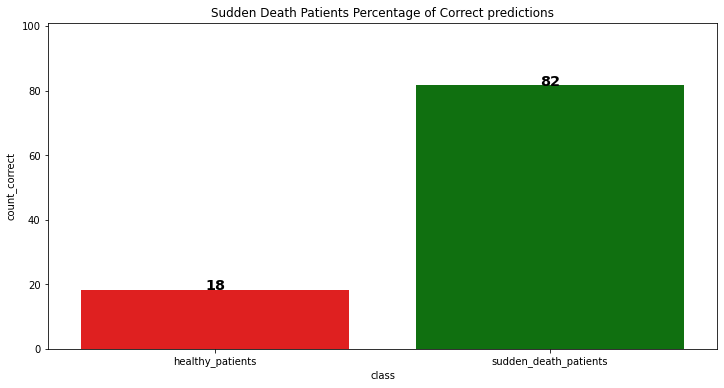

In [19]:
plt.figure(figsize=[12,6])
colors = ['red','green']
ax = sns.barplot(x=grouped_unhealthy['class'],y=grouped_unhealthy['count_correct'],palette=colors)
plt.title('Sudden Death Patients Percentage of Correct predictions')
plt.xticks(range(2))
plt.ylim(0,101)
for index, row in grouped_unhealthy.iterrows():
    ax.text(row.name,row['count_correct'], round(row['count_correct']), color='black', ha="center",fontsize='x-large',weight='bold')
plt.show()

In [20]:
df_instants = df_unhealthy_final[['instant','patient','correct_class','instant_s']]

In [21]:
df_instants = df_instants.loc[df_instants['correct_class'] == -1].reset_index(drop = True)

In [22]:
df_instants

,instant,patient,correct_class,instant_s
0,t11,39,-1.0,4405s-4410s
1,t0,41,-1.0,3455s-3460s
2,t2,41,-1.0,3465s-3470s
3,t3,41,-1.0,3470s-3475s
4,t4,41,-1.0,3475s-3480s
...,...,...,...,...
61,t21,51,-1.0,5610s-5615s
62,t24,51,-1.0,5625s-5630s
63,t27,51,-1.0,5640s-5645s
64,t2,52,-1.0,8375s-8380s


In [23]:
df_instants['instant_x'] = df_instants['instant_s'].str.replace(r'(\d+)s.*',r'\1',regex=True)

In [24]:
df_instants['instant_xn'] = df_instants['instant_s'].str.replace(r'(\d+)s-(\d+)s',r'\2',regex=True)

In [25]:
df_instants

,instant,patient,correct_class,instant_s,instant_x,instant_xn
0,t11,39,-1.0,4405s-4410s,4405,4410
1,t0,41,-1.0,3455s-3460s,3455,3460
2,t2,41,-1.0,3465s-3470s,3465,3470
3,t3,41,-1.0,3470s-3475s,3470,3475
4,t4,41,-1.0,3475s-3480s,3475,3480
...,...,...,...,...,...,...
61,t21,51,-1.0,5610s-5615s,5610,5615
62,t24,51,-1.0,5625s-5630s,5625,5630
63,t27,51,-1.0,5640s-5645s,5640,5645
64,t2,52,-1.0,8375s-8380s,8375,8380


In [26]:
int(df_instants.iloc[0]['instant_x']) * 250

1101250

In [27]:
int(df_instants.iloc[0]['instant_xn']) * 250

1102500

In [28]:
for filename in lista_filenames:
    name = filename.replace('.txt','')
    df_instant_patient = df_instants.loc[df_instants['patient'] == name].reset_index(drop = True)
    if len(df_instant_patient) == 0:
        pass
    else:
        df_patient = pd.read_csv(f'../../data/raw/sudden_death_patients/{filename}',sep=';')
        for i in range(len(df_instant_patient)):
            index_x = int(df_instant_patient.iloc[i]['instant_x']) * 250
            index_xn = int(df_instant_patient.iloc[i]['instant_xn']) * 250
            instant_x = int(df_instant_patient.iloc[i]['instant_x'])
            instant_xn = int(df_instant_patient.iloc[i]['instant_xn'])          
            df_patient_x_xn = df_patient.iloc[index_x:index_xn]
            
            df_patient_x_xn.to_csv(f'../../data/trials/{name}/instants/{name}_{instant_x}_{instant_xn}.txt')

In [29]:
listao = []

In [30]:
from os import listdir
from os.path import isfile, join
for filename in lista_filenames:
    name = filename.replace('.txt','')
    onlyfiles = [f for f in listdir(f'../../data/trials/{name}/instants') if isfile(join(f'../../data/trials/{name}/instants', f))]
    lista_files = []
    for item in onlyfiles:
        lista_files.append(f'../../data/trials/{name}/instants/' + item)
    listao.extend(lista_files)

In [34]:
'''
for number in [10,20,50,100]:
    for filepath in listao:
        df_smooth = pd.read_csv(filepath,sep=',')
        name = pd.DataFrame([filepath.replace('../../data/trials/','')])[0].str.replace(r'(\d+).*',r'\1',regex=True).values[0]
        instant_x = pd.DataFrame([filepath.replace('../../data/trials/','')])[0].str.replace(r'(\d+)/instants/(\d+)_(\d+)_(\d+).txt',r'\3',regex=True).values[0]
        instant_xn = pd.DataFrame([filepath.replace('../../data/trials/','')])[0].str.replace(r'(\d+)/instants/(\d+)_(\d+)_(\d+).txt',r'\4',regex=True).values[0]
        instant_x = int(instant_x)
        instant_xn = int(instant_xn)
        mylist = df_smooth['0']
        N = number
        cumsum, moving_aves = [0], []

        for i, x in enumerate(mylist, 1):
            cumsum.append(cumsum[i-1] + x)
            if i>=N:
                moving_ave = (cumsum[i] - cumsum[i-N])/N
                #can do stuff with moving_ave here
                moving_aves.append(moving_ave)

        df_mean = pd.DataFrame(moving_aves)
        df_mean.rename(columns={0:'signal'},inplace = True)
        
        plt.figure(figsize = [10,10])
        plt.style.use('seaborn-whitegrid')
        # Set Matplotlib defaults
        plt.rc('figure', autolayout=True)
        plt.rc('axes', labelweight='bold', labelsize='large',
               titleweight='bold', titlesize=18, titlepad=10)
        plt.subplot(2, 1, 1)
        img = mpimg.imread(f'../../data/trials/{name}/data/{name}.txt_{instant_x}s-{instant_xn}s.png')
        plt.imshow(img)
        plt.subplot(2, 1, 2)
        sns.lineplot(data=df_mean,y='signal',x=df_mean.index)
        plt.title(f'result: -1 patient_{name}_instant_{instant_x}_{instant_xn}_{number}')
        plt.savefig(f'../../data/trials/{name}/moving_mean/{name}_{instant_x}_{instant_xn}_smoothing_{number}.png')
'''

"\nfor number in [10,20,50,100]:\n    for filepath in listao:\n        df_smooth = pd.read_csv(filepath,sep=',')\n        name = pd.DataFrame([filepath.replace('../../data/trials/','')])[0].str.replace(r'(\\d+).*',r'\x01',regex=True).values[0]\n        instant_x = pd.DataFrame([filepath.replace('../../data/trials/','')])[0].str.replace(r'(\\d+)/instants/(\\d+)_(\\d+)_(\\d+).txt',r'\x03',regex=True).values[0]\n        instant_xn = pd.DataFrame([filepath.replace('../../data/trials/','')])[0].str.replace(r'(\\d+)/instants/(\\d+)_(\\d+)_(\\d+).txt',r'\x04',regex=True).values[0]\n        instant_x = int(instant_x)\n        instant_xn = int(instant_xn)\n        mylist = df_smooth['0']\n        N = number\n        cumsum, moving_aves = [0], []\n\n        for i, x in enumerate(mylist, 1):\n            cumsum.append(cumsum[i-1] + x)\n            if i>=N:\n                moving_ave = (cumsum[i] - cumsum[i-N])/N\n                #can do stuff with moving_ave here\n                moving_aves.app

In [32]:
listao = ['../../data/trials/39/instants_correct/39_4400_4405.txt','../../data/trials/39/instants_correct/39_4410_4415.txt']

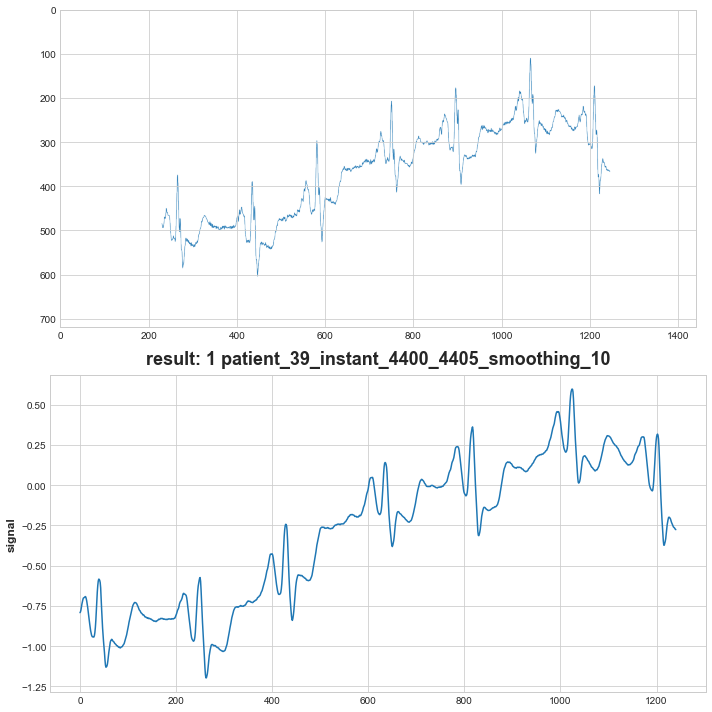

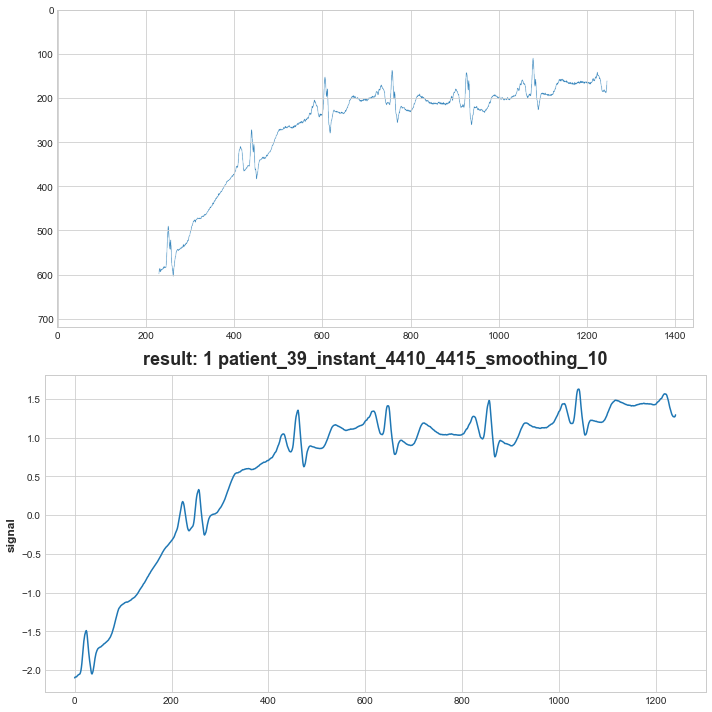

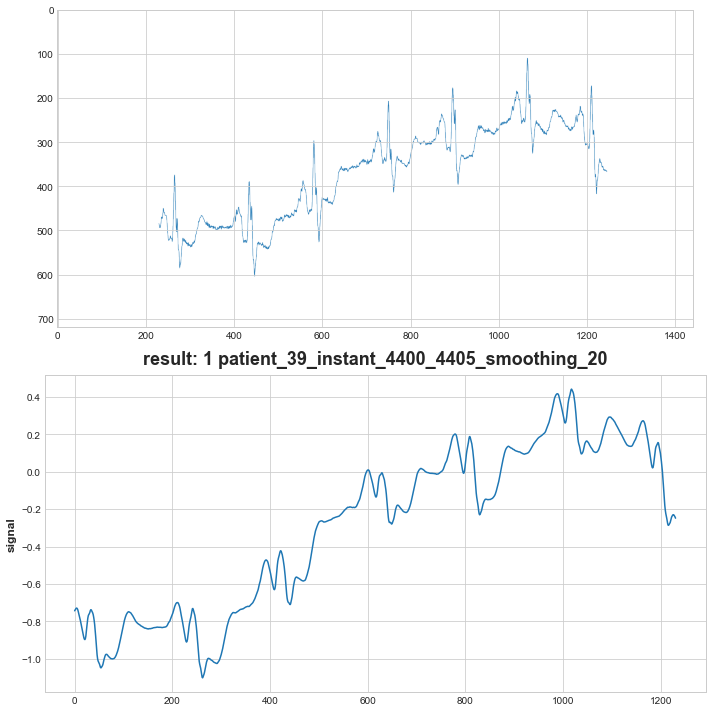

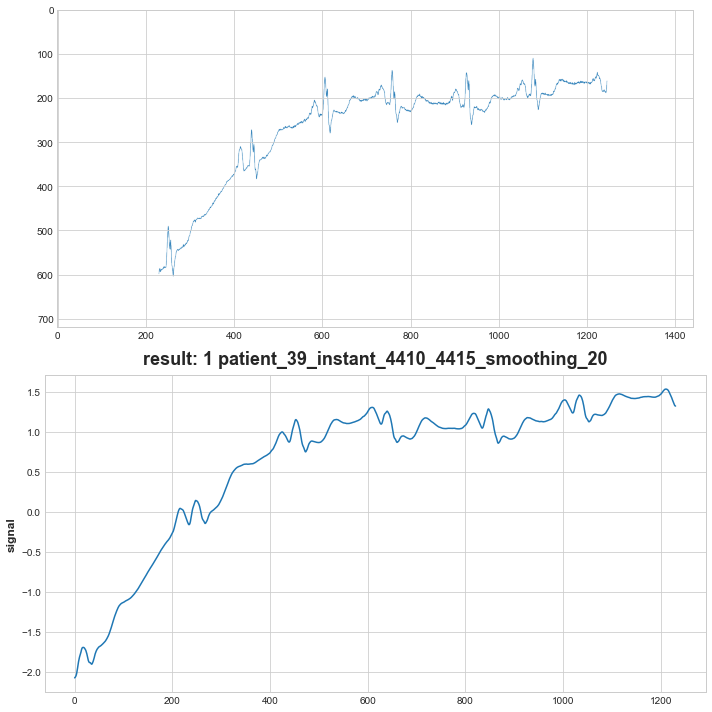

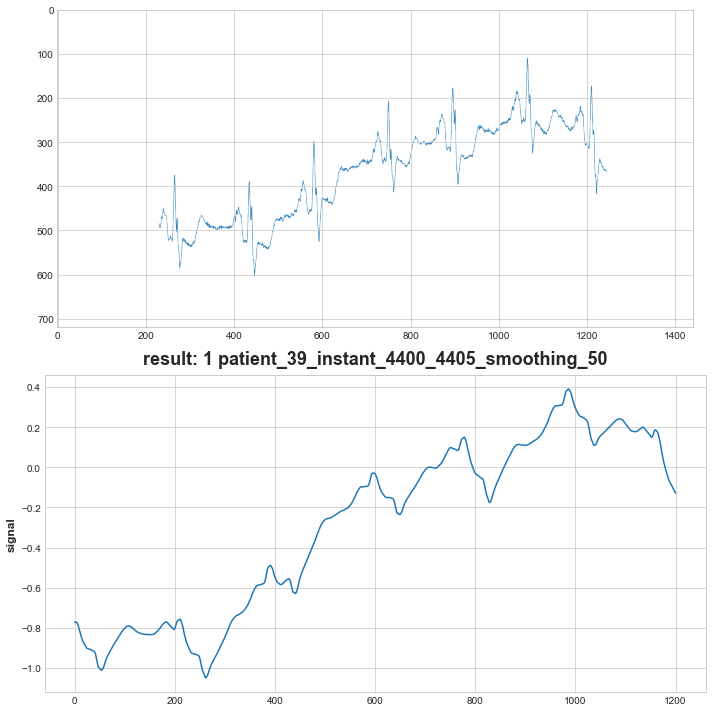

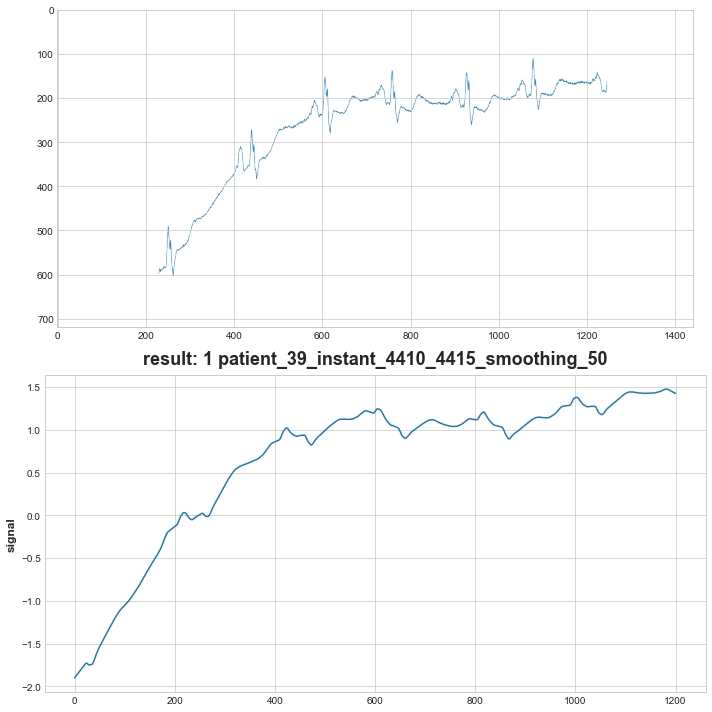

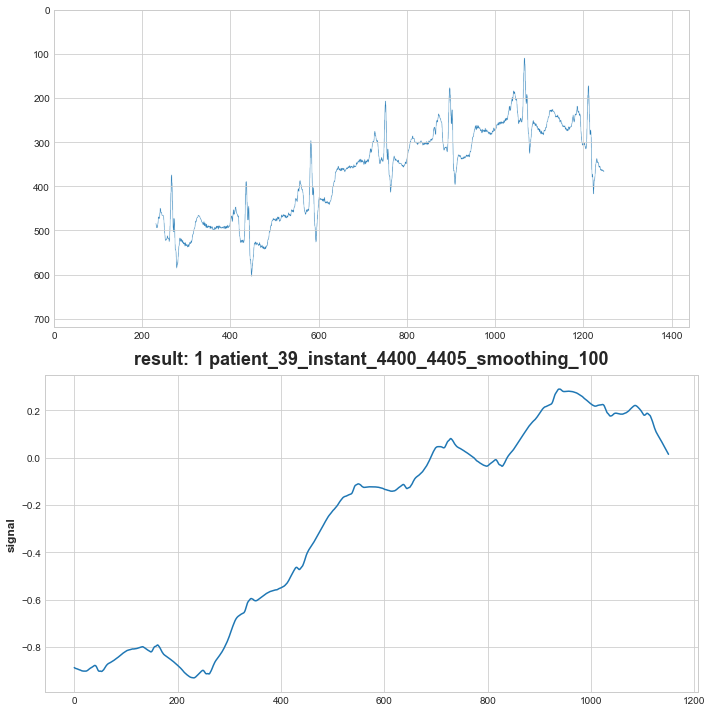

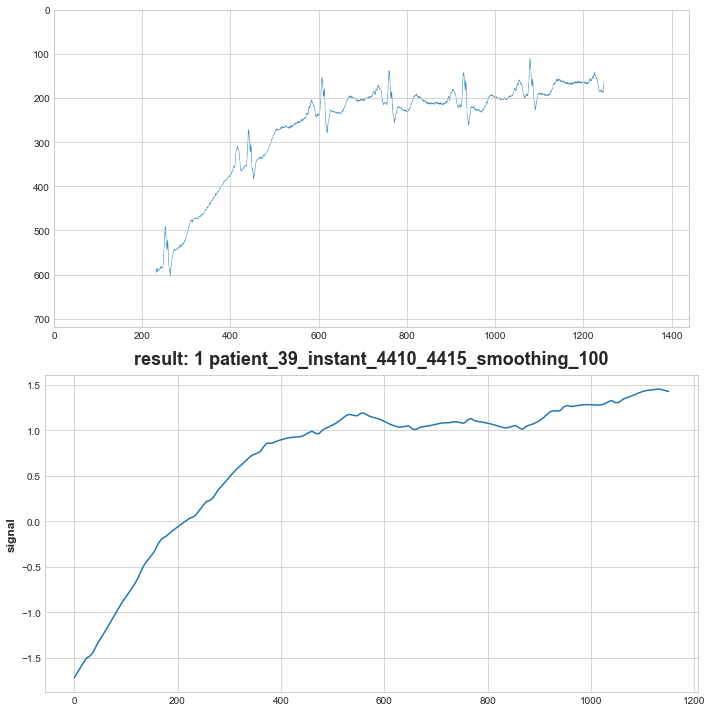

In [33]:
for number in [10,20,50,100]:
    for filepath in listao:
        df_smooth = pd.read_csv(filepath,sep=',')
        name = pd.DataFrame([filepath.replace('../../data/trials/','')])[0].str.replace(r'(\d+).*',r'\1',regex=True).values[0]
        instant_x = pd.DataFrame([filepath.replace('../../data/trials/','')])[0].str.replace(r'(\d+)/instants_correct/(\d+)_(\d+)_(\d+).txt',r'\3',regex=True).values[0]
        instant_xn = pd.DataFrame([filepath.replace('../../data/trials/','')])[0].str.replace(r'(\d+)/instants_correct/(\d+)_(\d+)_(\d+).txt',r'\4',regex=True).values[0]
        instant_x = int(instant_x)
        instant_xn = int(instant_xn)
        mylist = df_smooth['0']
        N = number
        cumsum, moving_aves = [0], []

        for i, x in enumerate(mylist, 1):
            cumsum.append(cumsum[i-1] + x)
            if i>=N:
                moving_ave = (cumsum[i] - cumsum[i-N])/N
                #can do stuff with moving_ave here
                moving_aves.append(moving_ave)

        df_mean = pd.DataFrame(moving_aves)
        df_mean.rename(columns={0:'signal'},inplace = True)
        
        plt.figure(figsize = [10,10])
        plt.style.use('seaborn-whitegrid')
        # Set Matplotlib defaults
        plt.rc('figure', autolayout=True)
        plt.rc('axes', labelweight='bold', labelsize='large',
               titleweight='bold', titlesize=18, titlepad=10)
        plt.subplot(2, 1, 1)
        img = mpimg.imread(f'../../data/trials/{name}/data/{name}.txt_{instant_x}s-{instant_xn}s.png')
        plt.imshow(img)
        plt.subplot(2, 1, 2)
        sns.lineplot(data=df_mean,y='signal',x=df_mean.index)
        plt.title(f'result: 1 patient_{name}_instant_{instant_x}_{instant_xn}_smoothing_{number}')
        plt.savefig(f'../../data/trials/{name}/moving_mean_correct/{name}_{instant_x}_{instant_xn}_smoothing_{number}.png')